### Important notice : this notebook works under @rom1lebogoss conda env and not under @autoqchem conda env...

# Import tools

In [1]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*') 

import sys
sys.path.append('../')
import dft_descriptors.fragmentation as fg

import gc
gc.collect()

4

# Load data

In [2]:
df = pd.read_csv('../data_csv/Data_test09032021.csv', sep = ',')

# Check if data is clean

In [3]:
for i in df["Product"]:
    m = Chem.MolFromSmiles(i,sanitize=False)
    if m is None:
          print('invalid', i)
            
for i in df["Reactant Smile (C-O)"]:
    m = Chem.MolFromSmiles(i,sanitize=False)
    if m is None:
          print('invalid', i)

# Generate fragments for the substrate on the C-O involved in the coupling 

In [4]:
unik_react = []
corr_product = []
for i, smi in enumerate(df["Reactant Smile (C-O)"]):
    can_smi = Chem.MolToSmiles(Chem.MolFromSmiles(smi))
    if can_smi not in unik_react:
        unik_react.append(can_smi)
        corr_product.append(df["Product"][i])

fragC = []
fragO = []
for i in range(len(unik_react)):
    smi = unik_react[i]
    frag = fg.gen_frag_on_CO_break(unik_react[i], corr_product[i])
    if len(frag) > 1:
        fragC.append(frag[0])
        fragO.append(frag[1])
    elif len(frag) == 1:
        fragC.append(frag[0])
        fragO.append('nan')

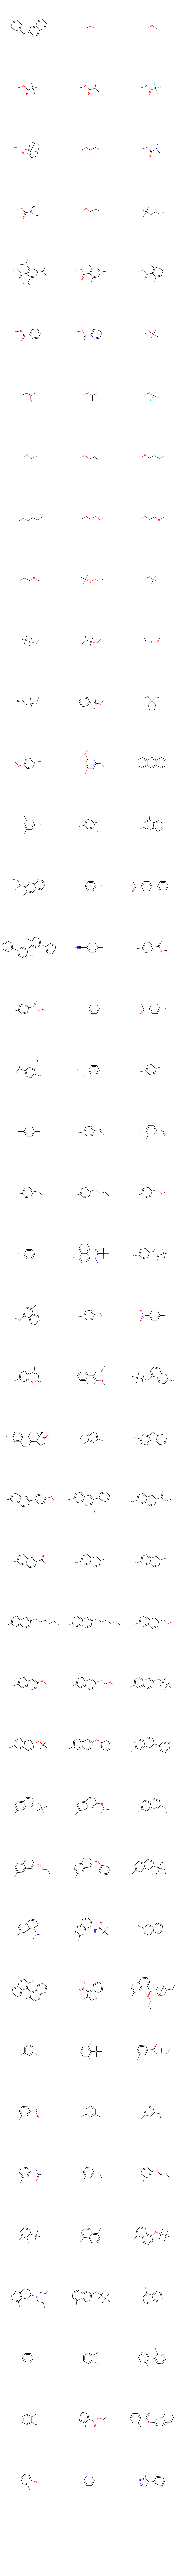

In [10]:
L = [Chem.MolFromSmiles(smi) for smi in np.unique(fragO)]
Draw.MolsToGridImage(L, subImgSize=(400, 400), maxMols = 200)

# Generate the corresponding dataframe and a .csv 

In [5]:
df2 = pd.DataFrame(data={"react": unik_react, "fragC": fragC, "fragO": fragO, "product": corr_product})
#df2.to_csv("../data_csv/fragments.csv", sep=',',index=False)

# Visualise the different fragmentation in order to correct potentials errors

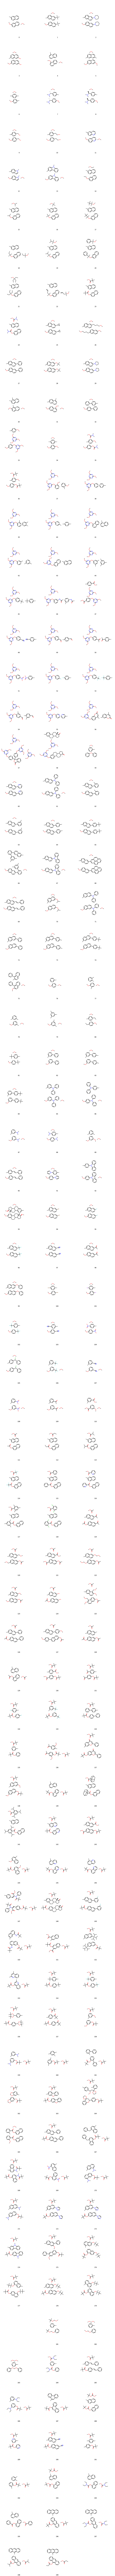

In [13]:
# better do it by slices of 200 molecules !
verif_mols = []
L=[str(i) for i in range(len(unik_react))]
for i in range(len(unik_react)):
    verif_mols.append(Chem.MolFromSmiles(str(unik_react[i]+"."+fragC[i]+"."+fragO[i])))
    
Draw.MolsToGridImage(verif_mols[:200], subImgSize=(400, 400), maxMols = 200, legends = L[:200])

###### an eventual manual correction can be done and fragment.csv can be updated
###### In this example molecules : 5, 31, 34, 57, 59, 89, 128, 164, 180, 222, 261 - 265, 269, 291 - 294, 301, 302, 306, 324, 334, 335, 349, 350, 351, 352, 356, 375, 376, 391

In [7]:
id_frags_to_modify = [5, 31, 34, 57, 59, 89, 128, 164, 180, 222, 261, 262, 263, 264, 
                      265, 269, 291, 292, 293, 294, 301, 302, 303, 306, 324, 334, 335, 349, 
                      350, 351, 352, 356, 375, 376, 391] 
df3 = pd.read_csv("../data_csv/fragments.csv", sep=',')

###### Rules are neaded to see if we keep some fragments or if we decide to remove them all, especially for the substrates undergoing a double coupling

In [8]:
df3.loc[57]

react      COc1nc(OC)nc(Oc2ccc(C3(c4ccc(Oc5nc(OC)nc(OC)n5...
fragC                                     *Oc1nc(OC)nc(OC)n1
fragO                                     *Oc1nc(OC)nc(OC)n1
product    O=C5OC(c2ccc(c1ccccc1)cc2)(c4ccc(c3ccccc3)cc4)...
Name: 57, dtype: object

###### Brute force method : remove all the wrong id 

In [9]:
df4 = df3.drop(index=id_frags_to_modify)
#df4.to_csv("../data_csv/fragments_corrected.csv", sep=',',index=False)

In [16]:
df5 = pd.read_csv("../data_csv/fragments_corrected.csv", sep=',')

In [26]:
L = [Chem.MolFromSmiles(smi) for smi in np.unique(df5["fragC"])]
Draw.MolsToGridImage(L, subImgSize=(400, 400), maxMols = 200)
print(len(L))

163


In [27]:
L = [Chem.MolFromSmiles(smi) for smi in np.unique(df5["fragO"])]
Draw.MolsToGridImage(L, subImgSize=(400, 400), maxMols = 200)
print(len(L))

110


In [28]:
df5

react                         fragC  \
0                          COc1ccc2ccccc2c1               *c1ccc2ccccc2c1   
1             COc1ccc2cc([Si](C)(C)C)ccc2c1  *c1ccc2cc([Si](C)(C)C)ccc2c1   
2                COc1ccc2cc(N3CCCCC3)ccc2c1     *c1ccc2cc(N3CCCCC3)ccc2c1   
3                       COc1ccc2ccc(O)cc2c1            *c1ccc2ccc(O)cc2c1   
4                          COc1cccc2ccccc12               *c1cccc2ccccc12   
..                                      ...                           ...   
354            CCCCc1ccc(OC(=O)C(C)(C)C)cc1               *OC(=O)C(C)(C)C   
355  CC(C)(C)C(=O)Nc1ccc(OC(=O)C(C)(C)C)cc1               *OC(=O)C(C)(C)C   
356              CC(C)(C)C(=O)Oc1ccc(Cl)cc1                 *c1ccc(Cl)cc1   
357             CC(C)(C)C(=O)Oc1ccc(C#N)cc1                *c1ccc(C#N)cc1   
358                  CC(C)(C)C(=O)Oc1ccncc1                     *c1ccncc1   

                         fragO  \
0                          *OC   
1                          *OC   
2                          *OC   
3                          *OC   
4                          *OC   
..                         ...   
354            *c1ccc(CCCC)cc1   
355  *c1ccc(NC(=O)C(C)(C)C)cc1   
356            *OC(=O)C(C)(C)C   
357            *OC(=O)C(C)(C)C   
358            *OC(=O)C(C)(C)C   

                                              product  
0                            c3ccc(c2ccc1ccccc1c2)cc3  
1                 C[Si](C)(C)c3ccc2cc(c1ccccc1)ccc2c3  
2                  c4ccc(c3ccc2cc(N1CCCCC1)ccc2c3)cc4  
3                           Oc3ccc2ccc(c1ccccc1)cc2c3  
4                            c3ccc(c1cccc2ccccc12)cc3  
..                                                ...  
354                 CCCCc1ccc(P(=O)(OC(C)C)OC(C)C)cc1  
355       CC(C)OP(=O)(OC(C)C)c1ccc(NC(=O)C(C)(C)C)cc1  
356  CC(C)OP(=O)(OC(C)C)c1ccc(P(=O)(OC(C)C)OC(C)C)cc1  
357                  CC(C)OP(=O)(OC(C)C)c1ccc(C#N)cc1  
358                       CC(C)OP(=O)(OC(C)C)c1ccncc1  

[359 rows x 4 columns]